<br>
<font>
<!-- <img src="https://sina.sharif.edu/~m_salehi/images/logo_sharif.png" alt="SUT logo" width=300 height=300 align=left class="saturate"> -->
<div dir=ltr align=center>
<img src="https://sina.sharif.edu/~m_salehi/images/logo_sharif.png" width=160 height=180>
<br>
<font color=0F5298 size=6>
Introduction to Machine Learning <br>
<font color= 6C3BAA size=6>
Neural Networks with PyTorch <br>
<font color=696880 size=5>
<!-- <br> -->
Computer Engineering Department
<br>
Sharif University of Technology

<font color=696880 size=5>
<br>
CE 40477 - Fall 2025

<font color=GREEN size=5>
<br>
Hossein Shahabadi & Farzan Rahmani
<!-- <br> -->

# Table of Contents

* ## [Imports and Setup](#imports-and-setup)
* ## [Dataset](#dataset)
* ## [Data Loaders](#data-loaders)
* ## [Visualization](#visualization)
* ## [Device](#device)
* ## [Neural Network](#neural-network)
* ## [Training Loop](#training-loop)
* ## [Testing](#testing)
* ## [Experiments](#experiments)
* ## [References](#references)

<a id="imports-and-setup"></a>
## Imports and Setup

We start by importing necessary modules. Don't worry if it seems a little overwhelming at first.

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
# @title plotting functions

from matplotlib import pyplot as plt
from tqdm import trange

def visualize(images, labels):
    """
    Visualize a batch of images.
    """
    fig, axes = plt.subplots(8, 8, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].squeeze(), cmap='gray')
        ax.set_title(f'Label: {labels[i].item()}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()


def visualize_predictions(images, labels, predicted_labels):
    """
    Visualize a batch of images with their true and predicted labels.
    Titles are green if the prediction is correct, red if incorrect.
    """
    fig, axes = plt.subplots(8, 8, figsize=(11, 12))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].squeeze(), cmap='gray')
        color = 'green' if labels[i].item() == predicted_labels[i].item() else 'red'
        ax.set_title(f'True: {labels[i].item()}\nPred: {predicted_labels[i].item()}', color=color)
        ax.axis('off')

    plt.tight_layout()
    plt.show()


def plot_conf_mat(model, dataloader, device):
    """
    Plot the confusion matrix for a given model and dataloader.
    """
    # Initialize the confusion matrix
    total, correct = 0, 0
    conf_mat = torch.zeros((10, 10))
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            total += pred.shape[0]
            pred = torch.argmax(pred, axis=1)
            correct += sum(pred == y).item()
            for j in range(pred.shape[0]):
                conf_mat[y[j], pred[j].item()] += 1
    # calculate the normalized confusion matrix
    norm_conf_mat = conf_mat / torch.sum(conf_mat, axis=1)
    # plot the matrix
    fig, ax = plt.subplots()
    plt.imshow(norm_conf_mat)
    plt.title('Confusion Matrix')
    plt.xlabel('Predictions')
    plt.ylabel('Labels')
    plt.xticks(range(10))
    plt.yticks(range(10))
    plt.colorbar()
    # put number of each cell in plot
    for i in range(10):
        for j in range(10):
            c = conf_mat[j, i]
            color = 'black' if c > 500 else 'white'
            ax.text(i, j, str(int(c)), va='center', ha='center', color=color)
    plt.show()

<a id="dataset"></a>
# Dataset

We will use `datasets` from `torchvision` to load the [MNIST](https://yann.lecun.com/exdb/mnist/) handwritten digits dataset. You can find the list of datasets available on torchvision [here](https://pytorch.org/vision/0.8/datasets.html). Now let's take a loot at the parameters we set:



*   `root` sets the directory we store and load our data from.
*   `train` indicates wether we want the training dataset or the test dataset.
*   `transform` allows us to apply transformations to our data, here we are only going to convert the data to tensor so that they work with PyToch, however in the future notebooks you will see more complicated transformations.



In [3]:
# Download training data from open datasets.
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)


print(f"Training data: {training_data}\n")
print(f"Test data: {test_data}")

Training data: Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

Test data: Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


As you can see there are 60000 training samples in the training dataset and there are 10000 samples in the test dataset.

<a id="data-loaders"></a>
# Data Loaders

To make loading and working with the data easier, we are going to use `DataLoader` from `torch.utils.data`. The `DataLoader` takes in a dataset and a `batch_size` parameter, and allows us to iterate over the dataset. Here we do one iteration just to see the data shapes:

In [4]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

# Iterate over the data
for x, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {x.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


As you can see the `x`s are of shape `[64, 1, 28, 28]` which means we have a batch of `64` images, each with `1` channel which means the images are grayscale (for example colorful images have 3 channels of red, blue and green or RGB), and of size `28x28` pixels.

Similarly the `y`s are of shape `[64]` which means we have a batch of 64 labels. In the next section we will learn more about these labels.

<a id="visualization"></a>
# Visualization

Here we will take a look at single batch of data and visualize it.

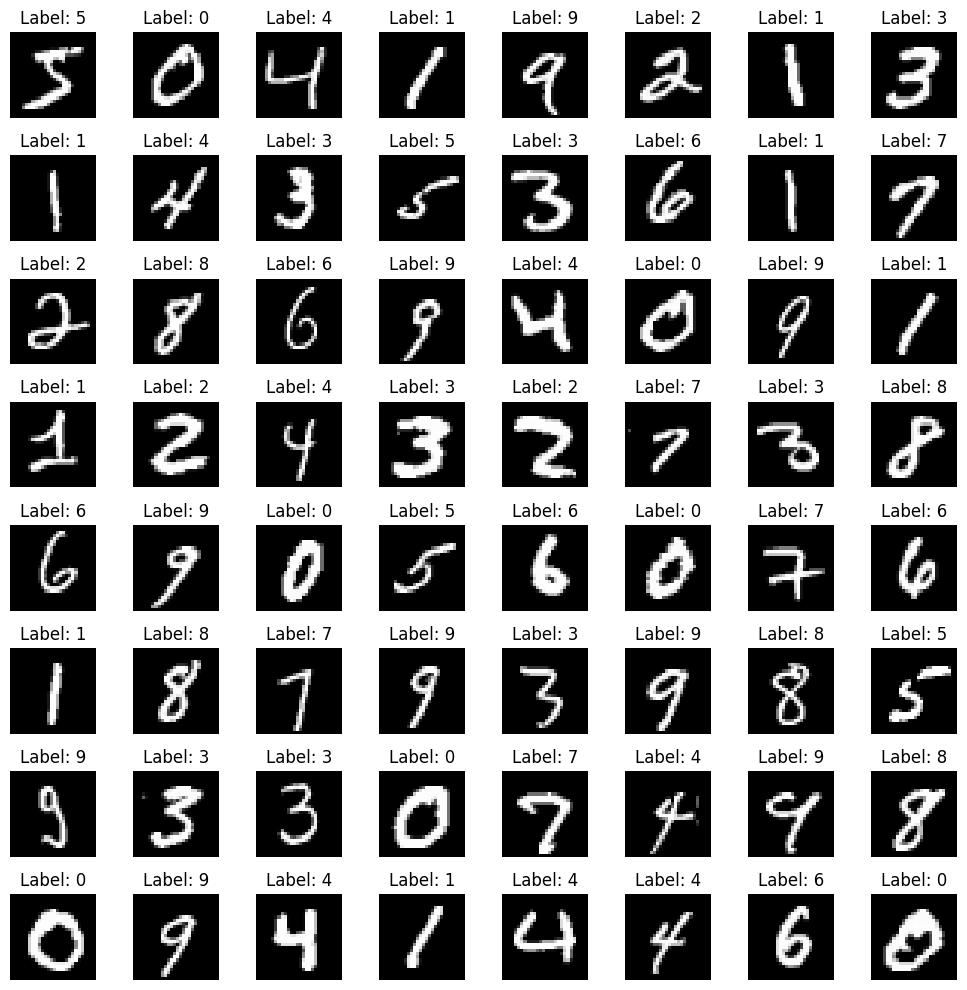

In [5]:
images, labels = next(iter(train_dataloader))

visualize(images, labels)

<a id="device"></a>
# Device

To accelerate operations in the neural network, we move it to the GPU or MPS (for Apple silicon) if available.

In [6]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


<a id="neural-network"></a>
# Model

Here we define our model. Recall that each batch of image has a shape of `[64, 1, 28, 28]`. For now we only want to use `Linear` layers so we must **flatten** the inputs so that we can pass it to the linear layers. The `nn.Flatten()` module allows us to do this.

In [7]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

Next we initialize our model.

In [8]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


# Loss Function

Since we are trying to classify the handwritten digits, we are going to use the cross entropy loss. You can see the list of loss functions in PyTorch [here](https://pytorch.org/docs/stable/nn.html#loss-functions).

In [9]:
loss_fn = nn.CrossEntropyLoss()

# Optimizer

Next we need to setup an optimizer for training our model. We use stochastic gradient descent so we have must use the `SGD` module from `torch.optim`. We must pass the `model.parameters()` to the `SGD` optimizer and set its learning rate `lr=1e-3`. In the following sessions you will learn more about different optimizers but can also learn about the optimizers available on PyTorch [here](https://pytorch.org/docs/stable/optim.html).

In [10]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

<a id="training-loop"></a>
# Training

To train the model we first set the number of epochs. For each epoch we then iterate over the entire training data and update the model parameters. For each batch of data, we must first move the data to same device as the network, then we predict the output of the model, calculate the loss, perform backward pass, update parameters, and reset the gradients.

To monitor training, we use `trange` from `tqdm` which performs similar to `range` but allows us to have a progress bar `pbar` which lets us display useful information.

In [11]:
# Number of epochs we wish to train the model
n_epochs = 30

for _ in (pbar := trange(n_epochs)):
    # Iterate over the data
    for x, y in train_dataloader:
        # Move the datapoints to same device as the model
        x, y = x.to(device), y.to(device)
        # Clear the gradients
        optimizer.zero_grad()
        # Predict the output and perform the forward pass
        pred = model(x)
        # Compute prediction error
        loss = loss_fn(pred, y)
        # Backpropagation
        loss.backward()
        # Update the model weights
        optimizer.step()
        # Update the progress bar
        pbar.set_description(f'Loss = {loss.item():.3f}')

  0%|                                                    | 0/30 [00:00<?, ?it/s]

Loss = 2.307:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.297:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.314:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.304:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.308:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.313:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.305:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.309:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.311:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.302:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.306:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.297:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.294:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.312:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.298:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.297:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.305:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.306:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.302:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.310:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.301:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.296:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.310:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.301:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.315:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.311:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.312:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.292:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.306:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.299:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.305:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.308:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.301:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.298:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.314:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.304:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.311:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.305:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.297:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.305:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.298:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.300:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.313:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.309:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.308:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.305:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.297:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.297:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.303:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.306:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.294:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.307:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.309:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.303:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.297:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.307:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.298:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.308:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.302:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.302:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.297:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.296:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.311:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.299:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.310:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.306:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.301:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.297:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.295:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.311:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.299:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.305:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.303:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.302:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.302:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.300:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.292:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.305:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.293:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.310:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.309:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.303:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.289:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.290:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.310:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.295:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.296:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.295:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.302:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.309:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.297:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.309:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.302:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.298:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.309:   0%|                                      | 0/30 [00:02<?, ?it/s]

Loss = 2.298:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.308:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.303:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.300:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.299:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.305:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.299:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.300:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.302:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.299:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.303:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.299:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.300:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.287:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.297:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.305:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.305:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.298:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.307:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.298:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.303:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.301:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.298:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.301:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.306:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.298:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.313:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.302:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.296:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.300:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.306:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.291:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.290:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.306:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.288:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.287:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.305:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.297:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.305:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.309:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.295:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.313:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.297:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.309:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.297:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.297:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.298:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.300:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.296:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.302:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.299:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.312:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.289:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.289:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.301:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.307:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.290:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.298:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.297:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.295:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.289:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.289:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.305:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.300:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.291:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.285:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.297:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.305:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.292:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.298:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.303:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.310:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.291:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.300:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.288:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.297:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.303:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.300:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.295:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.292:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.304:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.301:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.289:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.292:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.304:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.298:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.295:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.294:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.291:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.289:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.297:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.293:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.293:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.310:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.296:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.289:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.298:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.300:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.300:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.297:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.301:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.299:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.296:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.302:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.291:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.308:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.296:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.301:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.287:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.296:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.299:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.284:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.311:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.296:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.294:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.296:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.301:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.300:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.302:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.298:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.286:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.292:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.293:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.302:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.296:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.299:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.288:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.300:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.286:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.300:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.297:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.299:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.301:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.293:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.294:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.283:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.295:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.303:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.290:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.301:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.300:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.293:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.294:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.298:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.294:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.307:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.289:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.288:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.297:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.287:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.295:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.304:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.300:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.287:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.290:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.299:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.295:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.289:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.296:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.293:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.295:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.295:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.299:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.291:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.286:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.302:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.294:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.290:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.295:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.303:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.282:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.294:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.297:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.291:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.305:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.292:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.284:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.309:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.290:   0%|                                      | 0/30 [00:03<?, ?it/s]

Loss = 2.310:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.293:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.295:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.299:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.288:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.303:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.289:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.296:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.295:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.283:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.298:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.288:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.292:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.293:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.301:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.293:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.294:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.296:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.291:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.298:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.292:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.290:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.296:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.292:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.300:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.290:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.287:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.294:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.293:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.296:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.289:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.282:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.290:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.287:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.288:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.283:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.290:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.300:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.296:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.297:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.287:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.303:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.294:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.292:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.288:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.299:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.280:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.289:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.286:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.290:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.291:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.293:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.298:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.283:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.303:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.293:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.297:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.294:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.295:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.284:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.286:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.298:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.296:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.291:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.297:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.288:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.290:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.296:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.287:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.290:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.291:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.294:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.297:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.290:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.284:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.286:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.288:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.301:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.299:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.287:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.291:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.290:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.298:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.286:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.284:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.297:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.284:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.287:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.300:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.281:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.291:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.286:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.290:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.293:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.287:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.295:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.288:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.287:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.294:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.295:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.287:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.292:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.292:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.280:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.298:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.295:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.292:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.284:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.290:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.292:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.297:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.274:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.296:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.292:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.291:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.288:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.291:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.284:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.286:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.294:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.294:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.288:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.280:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.284:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.290:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.288:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.295:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.293:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.287:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.286:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.289:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.288:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.281:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.286:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.294:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.290:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.281:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.291:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.281:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.296:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.288:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.286:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.294:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.287:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.279:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.291:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.288:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.281:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.291:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.288:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.286:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.291:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.277:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.289:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.288:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.289:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.280:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.282:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.289:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.293:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.295:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.290:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.284:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.274:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.288:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.281:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.281:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.290:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.279:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.291:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.279:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.280:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.281:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.287:   0%|                                      | 0/30 [00:04<?, ?it/s]

Loss = 2.283:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.280:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.290:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.280:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.285:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.291:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.296:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.294:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.285:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.285:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.285:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.273:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.275:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.283:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.280:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.288:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.291:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.292:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.289:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.288:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.282:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.290:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.293:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.276:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.280:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.287:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.285:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.278:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.284:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.287:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.290:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.278:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.292:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.281:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.299:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.277:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.293:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.282:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.279:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.275:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.289:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.289:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.282:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.291:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.290:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.282:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.282:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.283:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.292:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.286:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.289:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.295:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.294:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.284:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.293:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.286:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.291:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.291:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.297:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.292:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.282:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.281:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.290:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.283:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.287:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.274:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.272:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.285:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.286:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.283:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.280:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.283:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.284:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.281:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.289:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.276:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.288:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.283:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.287:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.282:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.277:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.280:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.280:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.285:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.273:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.293:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.280:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.279:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.278:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.283:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.276:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.272:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.276:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.283:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.283:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.283:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.294:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.275:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.279:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.276:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.295:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.295:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.285:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.286:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.289:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.284:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.279:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.281:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.286:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.274:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.270:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.278:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.287:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.277:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.284:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.292:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.276:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.278:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.275:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.275:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.284:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.287:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.289:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.276:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.278:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.279:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.266:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.277:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.279:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.288:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.284:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.285:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.281:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.276:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.287:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.280:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.285:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.284:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.283:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.292:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.280:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.280:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.282:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.285:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.278:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.272:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.286:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.271:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.275:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.281:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.286:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.284:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.274:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.278:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.278:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.290:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.280:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.276:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.289:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.273:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.273:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.276:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.274:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.279:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.277:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.274:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.274:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.288:   0%|                                      | 0/30 [00:05<?, ?it/s]

Loss = 2.284:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.278:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.272:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.271:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.291:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.285:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.273:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.283:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.290:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.278:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.272:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.279:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.266:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.278:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.277:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.270:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.279:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.283:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.283:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.280:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.289:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.266:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.271:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.291:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.292:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.270:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.271:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.271:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.278:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.274:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.266:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.277:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.288:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.281:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.265:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.285:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.285:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.283:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.283:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.295:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.266:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.264:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.275:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.279:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.275:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.286:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.284:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.277:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.281:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.271:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.276:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.268:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.275:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.270:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.283:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.279:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.281:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.280:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.269:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.286:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.272:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.270:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.277:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.275:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.274:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.272:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.281:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.273:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.289:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.280:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.269:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.278:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.271:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.286:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.273:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.282:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.276:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.285:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.274:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.275:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.260:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.279:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.272:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.278:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.276:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.273:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.268:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.286:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.271:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.282:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.276:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.281:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.277:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.275:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.281:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.270:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.272:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.264:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.277:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.281:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.273:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.285:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.279:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.278:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.282:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.269:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.284:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.280:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.271:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.274:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.272:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.275:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.267:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.271:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.267:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.267:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.272:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.271:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.276:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.266:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.270:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.268:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.280:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.284:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.270:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.272:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.282:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.272:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.274:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.269:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.277:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.267:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.275:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.289:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.267:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.260:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.249:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.273:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.259:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.275:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.270:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.276:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.270:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.263:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.267:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.253:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.269:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.272:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.287:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.286:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.271:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.282:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.273:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.265:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.266:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.263:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.269:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.280:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.276:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.283:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.286:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.281:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.273:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.285:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.273:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.270:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.267:   0%|                                      | 0/30 [00:06<?, ?it/s]

Loss = 2.253:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.270:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.263:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.271:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.281:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.272:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.267:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.279:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.269:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.272:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.275:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.260:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.270:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.269:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.254:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.274:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.267:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.270:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.258:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.274:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.269:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.255:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.275:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.263:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.273:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.283:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.268:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.275:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.272:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.270:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.270:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.281:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.275:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.276:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.260:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.278:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.261:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.263:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.259:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.267:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.269:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.277:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.268:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.274:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.275:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.270:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.262:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.274:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.262:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.269:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.265:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.265:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.274:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.267:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.278:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.272:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.281:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.268:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.269:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.269:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.271:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.282:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.261:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.274:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.262:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.274:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.254:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.264:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.262:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.270:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.248:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.260:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.269:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.262:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.284:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.267:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.262:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.264:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.255:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.268:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.249:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.275:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.263:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.260:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.272:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.259:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.254:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.267:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.256:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.264:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.268:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.266:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.274:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.262:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.251:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.269:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.278:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.278:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.248:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.269:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.257:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.259:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.270:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.267:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.257:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.254:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.257:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.267:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.254:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.261:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.267:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.273:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.275:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.256:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.268:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.266:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.250:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.264:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.259:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.266:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.270:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.272:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.274:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.259:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.263:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.276:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.254:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.263:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.269:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.271:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.256:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.258:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.268:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.265:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.272:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.276:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.267:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.253:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.264:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.255:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.262:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.257:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.258:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.265:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.264:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.251:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.253:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.263:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.261:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.262:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.263:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.267:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.245:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.273:   0%|                                      | 0/30 [00:07<?, ?it/s]

Loss = 2.266:   0%|                                      | 0/30 [00:08<?, ?it/s]

Loss = 2.266:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.262:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.247:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.277:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.256:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.265:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.265:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.263:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.269:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.274:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.272:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.262:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.253:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.253:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.265:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.263:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.258:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.272:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.270:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.256:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.269:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.260:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.247:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.272:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.262:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.275:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.266:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.261:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.247:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.262:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.252:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.255:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.263:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.248:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.250:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.266:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.260:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.268:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.268:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.255:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.260:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.252:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.254:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.271:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.266:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.260:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.259:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.258:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.258:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.265:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.265:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.251:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.267:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.266:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.261:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.257:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.264:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.252:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.257:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.262:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.258:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.252:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.256:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.267:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.257:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.268:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.263:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.251:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.257:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.257:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.273:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.246:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.253:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.256:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.256:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.260:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.263:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.245:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.264:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.245:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.264:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.262:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.252:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.246:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.233:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.262:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.240:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.249:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.248:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.256:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.266:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.255:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.271:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.258:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.247:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.250:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.240:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.263:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.256:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.252:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.254:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.258:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.257:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.251:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.244:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.260:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.264:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.269:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.258:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.237:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.254:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.268:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.265:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.264:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.275:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.268:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.263:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.266:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.261:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.258:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.265:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.257:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.274:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.259:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.247:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.252:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.258:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.242:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.248:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.266:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.245:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.242:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.269:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.248:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.249:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.262:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.253:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.276:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.252:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.275:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.247:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.247:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.248:   3%|█                             | 1/30 [00:08<03:57,  8.19s/it]

Loss = 2.262:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.250:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.263:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.251:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.270:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.241:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.239:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.267:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.264:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.233:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.247:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.252:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.244:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.246:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.241:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.264:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.254:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.245:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.240:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.238:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.253:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.242:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.250:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.256:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.268:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.245:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.253:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.237:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.252:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.254:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.238:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.248:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.249:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.258:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.254:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.244:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.246:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.264:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.249:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.260:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.252:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.246:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.247:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.255:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.255:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.242:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.267:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.244:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.242:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.255:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.257:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.261:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.255:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.258:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.253:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.256:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.260:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.247:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.269:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.246:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.262:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.243:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.253:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.257:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.231:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.270:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.262:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.244:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.240:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.248:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.248:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.265:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.260:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.244:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.247:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.253:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.269:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.250:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.250:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.241:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.258:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.241:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.262:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.251:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.259:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.260:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.263:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.260:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.249:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.258:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.258:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.246:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.258:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.250:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.258:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.249:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.253:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.249:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.274:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.243:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.237:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.250:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.241:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.259:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.267:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.262:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.241:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.247:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.262:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.249:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.242:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.246:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.249:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.251:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.246:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.250:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.242:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.239:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.261:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.250:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.256:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.258:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.261:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.246:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.249:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.247:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.251:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.260:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.238:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.244:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.264:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.251:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.279:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.257:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.262:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.259:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.251:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.266:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.243:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.251:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.254:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.232:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.249:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.239:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.253:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.255:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.262:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.247:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.248:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.253:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.250:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.249:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.248:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.236:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.251:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.254:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.260:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.252:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.229:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.248:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.245:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.244:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.237:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.230:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.242:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.234:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.235:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.230:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.236:   3%|█                             | 1/30 [00:09<03:57,  8.19s/it]

Loss = 2.262:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.255:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.260:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.242:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.260:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.246:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.251:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.234:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.250:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.224:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.243:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.228:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.239:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.247:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.249:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.260:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.230:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.259:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.248:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.245:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.247:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.245:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.238:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.247:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.251:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.240:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.245:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.250:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.247:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.229:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.245:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.228:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.227:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.248:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.259:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.258:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.240:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.241:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.234:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.237:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.269:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.265:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.243:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.235:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.239:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.258:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.235:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.231:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.243:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.233:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.237:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.255:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.230:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.240:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.238:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.251:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.245:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.241:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.260:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.252:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.240:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.248:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.253:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.235:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.247:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.240:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.229:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.257:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.255:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.242:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.232:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.242:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.248:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.255:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.224:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.255:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.251:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.241:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.253:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.242:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.231:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.238:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.245:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.245:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.238:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.223:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.228:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.236:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.240:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.246:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.239:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.236:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.249:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.245:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.247:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.230:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.236:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.244:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.243:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.234:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.243:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.243:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.258:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.247:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.248:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.250:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.238:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.233:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.241:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.242:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.234:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.247:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.238:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.235:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.245:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.230:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.246:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.243:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.248:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.227:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.230:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.243:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.251:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.253:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.238:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.229:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.216:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.232:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.222:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.229:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.238:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.224:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.242:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.224:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.228:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.227:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.241:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.238:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.226:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.237:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.231:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.238:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.243:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.256:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.260:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.237:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.230:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.231:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.209:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.211:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.234:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.232:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.240:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.254:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.250:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.252:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.249:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.243:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.243:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.256:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.238:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.232:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.241:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.231:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.232:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.245:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.242:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.255:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.234:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.251:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.231:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.252:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.228:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.251:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.233:   3%|█                             | 1/30 [00:10<03:57,  8.19s/it]

Loss = 2.228:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.225:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.250:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.257:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.239:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.245:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.247:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.238:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.244:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.246:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.255:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.241:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.251:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.249:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.248:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.239:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.251:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.247:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.245:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.251:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.249:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.252:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.235:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.232:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.241:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.245:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.235:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.222:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.215:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.231:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.243:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.231:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.230:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.234:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.237:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.236:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.247:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.229:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.247:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.236:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.235:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.233:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.216:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.225:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.223:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.241:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.225:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.247:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.225:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.229:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.224:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.231:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.229:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.217:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.226:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.231:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.232:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.236:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.255:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.229:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.231:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.222:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.250:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.249:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.244:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.240:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.239:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.230:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.222:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.233:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.245:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.212:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.221:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.222:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.241:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.235:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.241:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.253:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.226:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.220:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.220:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.220:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.236:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.242:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.245:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.217:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.221:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.218:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.208:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.227:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.228:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.234:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.234:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.238:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.227:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.220:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.236:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.234:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.235:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.235:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.240:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.250:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.228:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.223:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.235:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.238:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.225:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.218:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.242:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.212:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.215:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.235:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.242:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.240:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.221:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.229:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.230:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.249:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.228:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.221:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.239:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.214:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.217:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.223:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.210:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.219:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.212:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.220:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.225:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.244:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.239:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.229:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.215:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.218:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.242:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.248:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.220:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.237:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.243:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.226:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.212:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.227:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.211:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.229:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.224:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.212:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.230:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.228:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.229:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.238:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.243:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.210:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.212:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.238:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.246:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.221:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.224:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.219:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.231:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.227:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.218:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.233:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.250:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.239:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.210:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.244:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.247:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.237:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.230:   3%|█                             | 1/30 [00:11<03:57,  8.19s/it]

Loss = 2.250:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.205:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.199:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.226:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.232:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.221:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.248:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.239:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.232:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.239:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.210:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.219:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.220:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.208:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.213:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.230:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.238:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.238:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.229:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.212:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.233:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.215:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.214:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.224:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.216:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.225:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.212:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.230:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.218:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.246:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.229:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.220:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.230:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.216:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.246:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.225:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.237:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.228:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.239:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.219:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.219:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.198:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.229:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.218:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.231:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.233:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.224:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.217:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.238:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.217:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.235:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.225:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.226:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.217:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.221:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.237:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.215:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.223:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.209:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.222:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.228:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.225:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.238:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.230:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.232:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.234:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.218:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.236:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.234:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.227:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.220:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.219:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.217:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.212:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.213:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.213:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.206:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.213:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.205:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.223:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.204:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.215:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.213:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.233:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.247:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.212:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.225:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.234:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.220:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.215:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.208:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.218:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.204:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.218:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.238:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.208:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.204:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.177:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.214:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.192:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.222:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.203:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.220:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.212:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.205:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.205:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.190:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.208:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.217:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.242:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.244:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.223:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.231:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.222:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.209:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.203:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.200:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.212:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.245:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.235:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.238:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.242:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.225:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.225:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.240:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.223:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.223:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.215:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.191:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.216:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.206:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.219:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.243:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.215:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.211:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.237:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.217:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.220:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.222:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.207:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.213:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.205:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.189:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.218:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.216:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.210:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.199:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.217:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.217:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.194:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.218:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.202:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.219:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.236:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.207:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.223:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.218:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.214:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.226:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.239:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.229:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.230:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.196:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.218:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.194:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.206:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.190:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.202:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.217:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.231:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.214:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.223:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.222:   3%|█                             | 1/30 [00:12<03:57,  8.19s/it]

Loss = 2.210:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.201:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.224:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.201:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.210:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.200:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.199:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.219:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.211:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.227:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.217:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.228:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.215:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.210:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.210:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.216:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.239:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.202:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.227:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.202:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.217:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.190:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.200:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.201:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.213:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.180:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.194:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.203:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.192:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.240:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.218:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.198:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.200:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.187:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.209:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.185:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.218:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.200:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.204:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.217:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.199:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.176:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.205:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.185:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.201:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.204:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.198:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.220:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.205:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.183:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.216:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.228:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.228:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.186:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.218:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.195:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.197:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.219:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.204:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.191:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.199:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.193:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.207:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.202:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.200:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.208:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.224:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.225:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.188:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.213:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.212:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.188:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.203:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.200:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.212:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.217:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.211:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.218:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.197:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.202:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.225:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.187:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.200:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.208:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.210:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.184:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.193:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.214:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.214:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.217:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.223:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.208:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.183:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.197:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.184:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.195:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.182:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.189:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.204:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.202:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.178:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.178:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.201:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.201:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.197:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.208:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.202:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.163:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.229:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.211:   3%|█                             | 1/30 [00:13<03:57,  8.19s/it]

Loss = 2.211:   7%|██                            | 2/30 [00:13<03:04,  6.57s/it]

Loss = 2.199:   7%|██                            | 2/30 [00:13<03:04,  6.57s/it]

Loss = 2.176:   7%|██                            | 2/30 [00:13<03:04,  6.57s/it]

Loss = 2.226:   7%|██                            | 2/30 [00:13<03:04,  6.57s/it]

Loss = 2.189:   7%|██                            | 2/30 [00:13<03:04,  6.57s/it]

Loss = 2.202:   7%|██                            | 2/30 [00:13<03:04,  6.57s/it]

Loss = 2.202:   7%|██                            | 2/30 [00:13<03:04,  6.57s/it]

Loss = 2.204:   7%|██                            | 2/30 [00:13<03:04,  6.57s/it]

Loss = 2.212:   7%|██                            | 2/30 [00:13<03:04,  6.57s/it]

Loss = 2.223:   7%|██                            | 2/30 [00:13<03:04,  6.57s/it]

Loss = 2.226:   7%|██                            | 2/30 [00:13<03:04,  6.57s/it]

Loss = 2.200:   7%|██                            | 2/30 [00:13<03:04,  6.57s/it]

Loss = 2.191:   7%|██                            | 2/30 [00:13<03:04,  6.57s/it]

Loss = 2.193:   7%|██                            | 2/30 [00:13<03:04,  6.57s/it]

Loss = 2.202:   7%|██                            | 2/30 [00:13<03:04,  6.57s/it]

Loss = 2.214:   7%|██                            | 2/30 [00:13<03:04,  6.57s/it]

Loss = 2.204:   7%|██                            | 2/30 [00:13<03:04,  6.57s/it]

Loss = 2.226:   7%|██                            | 2/30 [00:13<03:04,  6.57s/it]

Loss = 2.218:   7%|██                            | 2/30 [00:13<03:04,  6.57s/it]

Loss = 2.192:   7%|██                            | 2/30 [00:13<03:04,  6.57s/it]

Loss = 2.215:   7%|██                            | 2/30 [00:13<03:04,  6.57s/it]

Loss = 2.203:   7%|██                            | 2/30 [00:13<03:04,  6.57s/it]

Loss = 2.175:   7%|██                            | 2/30 [00:13<03:04,  6.57s/it]

Loss = 2.220:   7%|██                            | 2/30 [00:13<03:04,  6.57s/it]

Loss = 2.204:   7%|██                            | 2/30 [00:13<03:04,  6.57s/it]

Loss = 2.222:   7%|██                            | 2/30 [00:13<03:04,  6.57s/it]

Loss = 2.204:   7%|██                            | 2/30 [00:13<03:04,  6.57s/it]

Loss = 2.189:   7%|██                            | 2/30 [00:13<03:04,  6.57s/it]

Loss = 2.181:   7%|██                            | 2/30 [00:13<03:04,  6.57s/it]

Loss = 2.201:   7%|██                            | 2/30 [00:13<03:04,  6.57s/it]

Loss = 2.186:   7%|██                            | 2/30 [00:13<03:04,  6.57s/it]

Loss = 2.184:   7%|██                            | 2/30 [00:13<03:04,  6.57s/it]

Loss = 2.202:   7%|██                            | 2/30 [00:13<03:04,  6.57s/it]

Loss = 2.174:   7%|██                            | 2/30 [00:13<03:04,  6.57s/it]

Loss = 2.182:   7%|██                            | 2/30 [00:13<03:04,  6.57s/it]

Loss = 2.201:   7%|██                            | 2/30 [00:13<03:04,  6.57s/it]

Loss = 2.196:   7%|██                            | 2/30 [00:13<03:04,  6.57s/it]

Loss = 2.206:   7%|██                            | 2/30 [00:13<03:04,  6.57s/it]

Loss = 2.217:   7%|██                            | 2/30 [00:13<03:04,  6.57s/it]

Loss = 2.194:   7%|██                            | 2/30 [00:13<03:04,  6.57s/it]

Loss = 2.194:   7%|██                            | 2/30 [00:13<03:04,  6.57s/it]

Loss = 2.185:   7%|██                            | 2/30 [00:13<03:04,  6.57s/it]

Loss = 2.190:   7%|██                            | 2/30 [00:13<03:04,  6.57s/it]

Loss = 2.213:   7%|██                            | 2/30 [00:13<03:04,  6.57s/it]

Loss = 2.209:   7%|██                            | 2/30 [00:13<03:04,  6.57s/it]

Loss = 2.193:   7%|██                            | 2/30 [00:13<03:04,  6.57s/it]

Loss = 2.195:   7%|██                            | 2/30 [00:13<03:04,  6.57s/it]

Loss = 2.201:   7%|██                            | 2/30 [00:13<03:04,  6.57s/it]

Loss = 2.200:   7%|██                            | 2/30 [00:13<03:04,  6.57s/it]

Loss = 2.210:   7%|██                            | 2/30 [00:13<03:04,  6.57s/it]

Loss = 2.207:   7%|██                            | 2/30 [00:13<03:04,  6.57s/it]

Loss = 2.187:   7%|██                            | 2/30 [00:13<03:04,  6.57s/it]

Loss = 2.210:   7%|██                            | 2/30 [00:13<03:04,  6.57s/it]

Loss = 2.205:   7%|██                            | 2/30 [00:13<03:04,  6.57s/it]

Loss = 2.201:   7%|██                            | 2/30 [00:13<03:04,  6.57s/it]

Loss = 2.201:   7%|██                            | 2/30 [00:13<03:04,  6.57s/it]

Loss = 2.203:   7%|██                            | 2/30 [00:13<03:04,  6.57s/it]

Loss = 2.187:   7%|██                            | 2/30 [00:13<03:04,  6.57s/it]

Loss = 2.185:   7%|██                            | 2/30 [00:13<03:04,  6.57s/it]

Loss = 2.206:   7%|██                            | 2/30 [00:13<03:04,  6.57s/it]

Loss = 2.195:   7%|██                            | 2/30 [00:13<03:04,  6.57s/it]

Loss = 2.188:   7%|██                            | 2/30 [00:13<03:04,  6.57s/it]

Loss = 2.198:   7%|██                            | 2/30 [00:13<03:04,  6.57s/it]

Loss = 2.204:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.198:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.209:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.200:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.181:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.195:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.200:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.218:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.170:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.178:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.188:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.194:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.200:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.211:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.175:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.205:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.176:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.199:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.195:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.179:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.184:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.150:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.199:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.157:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.180:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.179:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.189:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.204:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.194:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.217:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.195:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.174:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.170:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.159:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.201:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.192:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.181:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.190:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.191:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.197:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.183:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.159:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.202:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.206:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.224:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.198:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.161:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.189:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.215:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.207:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.215:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.226:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.224:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.206:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.214:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.209:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.197:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.207:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.194:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.222:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.197:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.173:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.181:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.189:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.169:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.185:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.209:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.179:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.175:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.219:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.178:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.168:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.196:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.191:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.224:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.188:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.225:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.173:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.174:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.172:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.208:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.181:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.207:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.181:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.214:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.167:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.166:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.220:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.205:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.148:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.174:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.186:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.168:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.181:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.169:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.203:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.186:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.176:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.170:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.152:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.179:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.168:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.181:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.190:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.209:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.178:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.185:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.159:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.188:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.185:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.148:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.178:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.186:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.193:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.184:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.178:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.175:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.206:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.178:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.205:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.189:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.180:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.181:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.193:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.196:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.167:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.206:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.166:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.172:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.191:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.196:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.203:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.193:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.193:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.182:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.198:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.196:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.180:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.213:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.172:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.206:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.177:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.190:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.195:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.148:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.212:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.210:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.172:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.158:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.171:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.174:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.213:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.202:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.178:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.179:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.193:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.221:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.183:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.176:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.166:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.198:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.171:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.210:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.182:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.201:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.199:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.218:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.207:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.196:   7%|██                            | 2/30 [00:14<03:04,  6.57s/it]

Loss = 2.204:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.194:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.178:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.194:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.177:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.203:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.182:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.188:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.182:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.223:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.175:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.162:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.178:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.170:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.204:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.210:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.204:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.170:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.182:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.209:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.179:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.172:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.170:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.184:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.186:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.172:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.179:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.167:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.167:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.201:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.186:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.204:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.205:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.199:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.191:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.182:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.172:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.193:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.196:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.155:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.183:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.197:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.192:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.235:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.201:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.213:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.201:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.194:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.213:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.172:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.183:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.191:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.153:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.178:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.163:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.193:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.200:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.203:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.179:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.178:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.189:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.186:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.177:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.180:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.153:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.184:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.196:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.197:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.195:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.143:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.179:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.172:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.167:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.157:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.149:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.169:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.152:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.154:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.150:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.154:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.207:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.192:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.206:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.172:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.196:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.174:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.187:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.153:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.177:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.139:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.172:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.140:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.163:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.181:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.182:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.202:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.148:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.193:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.180:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.168:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.174:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.169:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.166:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.188:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.182:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.153:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.173:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.182:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.182:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.136:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.172:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.137:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.132:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.182:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.207:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.199:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.161:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.174:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.153:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.157:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.220:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.214:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.171:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.149:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.159:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.195:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.155:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.150:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.162:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.157:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.162:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.189:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.150:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.160:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.163:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.193:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.171:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.170:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.204:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.195:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.169:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.177:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.189:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.157:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.179:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.160:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.152:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.194:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.194:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.166:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.150:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.169:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.182:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.191:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.145:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.192:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.190:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.164:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.197:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.168:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.149:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.166:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.171:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.174:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.164:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.135:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.144:   7%|██                            | 2/30 [00:15<03:04,  6.57s/it]

Loss = 2.156:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.166:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.173:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.155:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.157:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.191:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.179:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.183:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.151:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.157:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.172:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.167:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.158:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.170:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.182:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.200:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.185:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.186:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.182:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.164:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.161:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.160:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.170:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.162:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.178:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.160:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.159:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.173:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.153:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.179:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.170:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.185:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.147:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.150:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.175:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.186:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.189:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.158:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.146:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.126:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.146:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.131:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.149:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.158:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.139:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.168:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.137:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.146:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.143:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.169:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.168:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.143:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.153:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.152:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.167:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.169:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.194:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.206:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.162:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.145:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.147:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.109:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.109:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.157:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.157:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.168:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.196:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.182:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.191:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.186:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.183:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.170:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.197:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.175:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.156:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.169:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.145:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.160:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.182:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.171:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.199:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.165:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.189:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.152:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.181:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.150:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.189:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.158:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.145:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.144:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.187:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.205:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.170:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.174:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.177:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.168:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.184:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.188:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.198:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.168:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.190:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.177:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.176:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.169:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.181:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.186:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.174:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.187:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.175:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.189:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.159:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.156:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.167:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.183:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.155:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.139:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.124:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.149:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.174:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.149:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.152:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.154:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.162:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.161:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.182:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.151:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.183:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.162:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.152:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.157:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.120:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.139:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.132:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.171:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.145:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.176:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.141:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.147:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.139:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.151:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.154:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.127:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.147:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.151:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.151:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.162:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.193:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.157:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.155:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.137:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.182:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.177:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.176:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.166:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.163:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.144:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.131:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.158:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.179:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.111:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.142:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.133:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.169:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.166:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.172:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.193:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.147:   7%|██                            | 2/30 [00:16<03:04,  6.57s/it]

Loss = 2.130:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.132:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.133:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.158:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.170:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.173:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.124:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.132:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.125:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.114:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.147:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.147:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.151:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.154:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.164:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.142:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.133:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.154:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.161:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.155:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.159:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.169:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.185:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.146:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.133:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.162:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.161:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.141:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.131:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.172:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.115:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.117:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.160:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.170:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.171:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.136:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.149:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.151:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.183:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.145:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.135:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.162:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.119:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.127:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.140:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.108:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.128:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.111:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.134:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.145:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.173:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.168:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.150:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.123:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.131:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.166:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.186:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.131:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.163:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.166:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.142:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.114:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.144:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.119:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.148:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.139:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.117:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.149:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.142:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.144:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.170:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.171:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.117:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.116:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.156:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.174:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.139:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.146:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.134:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.155:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.146:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.136:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.162:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.189:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.171:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.117:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.176:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.185:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.160:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.145:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.178:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.107:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.096:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.146:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.155:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.133:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.184:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.164:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.158:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.171:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.113:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.130:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.143:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.101:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.120:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.148:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.171:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.168:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.150:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.119:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.147:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.123:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.123:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.137:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.122:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.146:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.117:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.148:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.131:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.179:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.148:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.137:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.151:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.126:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.181:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.145:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.167:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.149:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.163:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.130:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.131:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.094:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.148:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.128:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.153:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.161:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.142:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.133:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.162:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.130:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.156:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.141:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.137:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.123:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.132:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.165:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.122:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.143:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.120:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.135:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.145:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.147:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.165:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.150:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.157:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.156:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.132:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.163:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.160:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.153:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.131:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.134:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.124:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.123:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.120:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.124:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.106:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.120:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.099:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.137:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.103:   7%|██                            | 2/30 [00:17<03:04,  6.57s/it]

Loss = 2.125:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.123:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.155:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.186:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.116:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.144:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.158:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.136:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.124:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.108:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.123:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.099:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.127:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.157:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.113:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.113:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.059:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.119:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.082:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.137:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.095:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.131:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.117:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.106:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.104:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.085:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.107:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.128:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.168:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.176:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.144:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.150:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.141:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.117:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.098:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.098:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.117:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.185:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.165:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.165:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.167:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.136:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.145:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.166:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.140:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.142:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.127:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.087:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.130:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.115:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.132:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.180:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.122:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.120:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.166:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.130:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.137:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.136:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.116:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.122:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.102:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.079:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.125:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.131:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.113:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.097:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.121:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.130:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.091:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.126:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.101:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.132:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.158:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.104:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.138:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.130:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.119:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.149:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.170:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.149:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.154:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.089:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.121:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.087:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.111:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.076:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.096:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.132:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.157:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.126:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.142:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.140:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.111:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.100:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.141:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.101:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.112:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.093:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.091:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.129:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.119:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.146:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.127:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.143:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.125:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.114:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.112:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.126:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.170:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.103:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.150:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.104:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.124:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.084:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.097:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.099:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.121:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.067:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.087:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.098:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.078:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.169:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.133:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.092:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.097:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.076:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.115:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.074:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.123:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.094:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.110:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.129:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.097:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.050:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.102:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.068:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.096:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.097:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.090:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.132:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.113:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.068:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.128:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.148:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.144:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.081:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.133:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.093:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.096:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.135:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.098:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.081:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.108:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.088:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.109:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.112:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.099:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.112:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.144:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.142:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.074:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.120:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.123:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.084:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.103:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.102:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.122:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.127:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.114:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.125:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.095:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.102:   7%|██                            | 2/30 [00:18<03:04,  6.57s/it]

Loss = 2.138:   7%|██                            | 2/30 [00:19<03:04,  6.57s/it]

Loss = 2.074:   7%|██                            | 2/30 [00:19<03:04,  6.57s/it]

Loss = 2.098:   7%|██                            | 2/30 [00:19<03:04,  6.57s/it]

Loss = 2.107:   7%|██                            | 2/30 [00:19<03:04,  6.57s/it]

Loss = 2.109:   7%|██                            | 2/30 [00:19<03:04,  6.57s/it]

Loss = 2.064:   7%|██                            | 2/30 [00:19<03:04,  6.57s/it]

Loss = 2.085:   7%|██                            | 2/30 [00:19<03:04,  6.57s/it]

Loss = 2.124:   7%|██                            | 2/30 [00:19<03:04,  6.57s/it]

Loss = 2.128:   7%|██                            | 2/30 [00:19<03:04,  6.57s/it]

Loss = 2.124:   7%|██                            | 2/30 [00:19<03:04,  6.57s/it]

Loss = 2.133:   7%|██                            | 2/30 [00:19<03:04,  6.57s/it]

Loss = 2.112:   7%|██                            | 2/30 [00:19<03:04,  6.57s/it]

Loss = 2.067:   7%|██                            | 2/30 [00:19<03:04,  6.57s/it]

Loss = 2.085:   7%|██                            | 2/30 [00:19<03:04,  6.57s/it]

Loss = 2.065:   7%|██                            | 2/30 [00:19<03:04,  6.57s/it]

Loss = 2.084:   7%|██                            | 2/30 [00:19<03:04,  6.57s/it]

Loss = 2.056:   7%|██                            | 2/30 [00:19<03:04,  6.57s/it]

Loss = 2.074:   7%|██                            | 2/30 [00:19<03:04,  6.57s/it]

Loss = 2.105:   7%|██                            | 2/30 [00:19<03:04,  6.57s/it]

Loss = 2.098:   7%|██                            | 2/30 [00:19<03:04,  6.57s/it]

Loss = 2.060:   7%|██                            | 2/30 [00:19<03:04,  6.57s/it]

Loss = 2.055:   7%|██                            | 2/30 [00:19<03:04,  6.57s/it]

Loss = 2.096:   7%|██                            | 2/30 [00:19<03:04,  6.57s/it]

Loss = 2.102:   7%|██                            | 2/30 [00:19<03:04,  6.57s/it]

Loss = 2.088:   7%|██                            | 2/30 [00:19<03:04,  6.57s/it]

Loss = 2.116:   7%|██                            | 2/30 [00:19<03:04,  6.57s/it]

Loss = 2.095:   7%|██                            | 2/30 [00:19<03:04,  6.57s/it]

Loss = 2.025:   7%|██                            | 2/30 [00:19<03:04,  6.57s/it]

Loss = 2.153:   7%|██                            | 2/30 [00:19<03:04,  6.57s/it]

Loss = 2.120:   7%|██                            | 2/30 [00:19<03:04,  6.57s/it]

Loss = 2.120:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.094:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.054:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.144:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.077:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.098:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.098:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.103:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.118:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.138:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.147:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.098:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.088:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.091:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.100:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.130:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.113:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.148:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.131:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.087:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.130:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.105:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.053:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.132:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.106:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.133:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.101:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.070:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.070:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.098:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.076:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.067:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.102:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.051:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.066:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.096:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.091:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.104:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.131:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.090:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.085:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.071:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.086:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.115:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.114:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.083:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.087:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.103:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.102:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.117:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.112:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.076:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.115:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.105:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.098:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.106:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.101:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.077:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.071:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.114:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.088:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.078:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.097:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.100:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.099:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.111:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.092:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.065:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.087:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.104:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.126:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.045:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.054:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.075:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.091:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.099:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.122:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.057:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.106:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.060:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.094:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.084:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.058:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.077:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.012:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.096:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.017:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.063:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.059:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.077:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.105:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.091:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.125:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.090:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.052:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.039:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.028:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.096:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.085:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.062:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.082:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.080:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.099:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.071:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.019:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.103:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.107:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.147:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.097:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.033:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.078:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.124:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.109:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.132:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.142:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.147:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.110:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.125:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.118:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.096:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.112:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.086:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.135:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.089:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.049:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.062:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.076:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.043:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.077:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.112:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.067:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.059:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.134:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.061:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.033:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.089:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.085:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.137:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.079:  10%|███                           | 3/30 [00:19<02:45,  6.12s/it]

Loss = 2.142:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.050:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.049:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.044:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.116:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.065:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.113:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.064:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.123:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.040:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.041:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.138:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.107:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.005:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.053:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.075:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.039:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.071:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.045:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.101:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.071:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.057:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.049:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.010:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.057:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.045:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.064:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.079:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.109:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.062:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.071:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.028:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.079:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.069:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.000:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.057:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.077:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.084:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.066:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.063:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.052:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.108:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.059:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.108:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.085:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.069:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.069:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.085:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.094:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.039:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.106:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.035:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.053:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.083:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.094:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.104:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.087:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.081:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.063:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.098:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.089:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.066:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.120:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.049:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.113:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.062:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.080:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.088:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.005:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.117:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.119:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.050:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.021:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.045:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.050:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.123:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.103:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.061:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.060:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.090:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.139:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.070:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.053:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.042:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.094:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.052:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.120:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.063:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.102:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.095:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.141:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.114:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.102:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.113:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.085:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.057:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.085:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.057:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.106:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.068:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.078:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.064:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.136:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.062:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.033:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.053:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.046:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.110:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.113:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.106:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.048:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.073:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.120:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.062:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.052:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.043:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.073:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.077:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.047:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.061:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.041:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.041:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.101:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.076:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.115:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.110:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.093:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.094:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.070:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.046:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.092:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.092:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.015:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.079:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.081:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.087:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.159:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.106:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.130:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.105:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.094:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.120:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.047:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.070:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.083:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.018:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.058:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.037:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.092:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.105:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.102:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.062:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.061:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.081:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.074:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.055:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.062:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.011:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.068:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.096:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.088:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.093:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.000:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.060:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.052:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.036:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.022:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.013:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.042:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.015:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.014:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.015:  10%|███                           | 3/30 [00:20<02:45,  6.12s/it]

Loss = 2.018:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.110:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.081:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.111:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.050:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.085:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.051:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.076:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.016:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.055:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 1.998:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.052:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 1.992:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.035:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.070:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.064:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.099:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.010:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.082:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.063:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.041:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.048:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.041:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.040:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.086:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.065:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.008:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.052:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.069:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.068:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 1.982:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.048:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 1.984:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 1.973:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.071:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.116:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.097:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.028:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.057:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.014:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.022:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.134:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.126:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.049:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.005:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.026:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.084:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.019:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.010:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.029:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.030:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.031:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.076:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.011:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.027:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.032:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.089:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.043:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.045:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.107:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.095:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.045:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.057:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.079:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.027:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.061:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.027:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.019:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.086:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.091:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.036:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.012:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.042:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.068:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.081:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.009:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.084:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.084:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.035:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.095:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.042:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.008:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.045:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.045:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.053:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.037:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 1.986:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.000:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.020:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.041:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.048:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.014:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.022:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.088:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.064:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.070:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.017:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.020:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.051:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.037:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.027:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.047:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.076:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.099:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.079:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.075:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.067:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.039:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.038:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.022:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.047:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.033:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.058:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.032:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.033:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.049:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.020:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.064:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.044:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.076:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.009:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.015:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.058:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.074:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.078:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.023:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.003:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 1.971:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 1.998:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 1.980:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.009:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.025:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 1.997:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.043:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 1.987:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.007:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 1.999:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.046:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.045:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 1.999:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.011:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.014:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.044:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.043:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.084:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.110:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.031:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 1.999:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.004:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 1.940:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 1.938:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.022:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.026:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.047:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.096:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.062:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.081:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.078:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.075:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.048:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.095:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.065:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.024:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.042:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 1.999:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.034:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.071:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.048:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.097:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.043:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.081:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.015:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.060:  10%|███                           | 3/30 [00:21<02:45,  6.12s/it]

Loss = 2.015:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.079:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.028:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.004:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.005:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.078:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.111:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.046:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.054:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.057:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.045:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.080:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.085:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.097:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.037:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.079:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.053:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.052:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.048:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.058:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.077:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.057:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.070:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.050:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.078:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.025:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.026:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.043:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.073:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.020:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 1.993:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 1.967:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.010:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.056:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.005:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.017:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.015:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.030:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.029:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.068:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.016:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.070:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.030:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.012:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.025:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 1.958:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 1.991:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 1.977:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.047:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.007:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.053:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 1.996:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.005:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 1.992:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.015:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.026:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 1.975:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.008:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.015:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.015:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.032:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.084:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.030:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.018:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 1.995:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.065:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.053:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.059:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.036:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.031:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 1.998:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 1.978:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.028:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.064:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 1.941:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.001:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 1.979:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.046:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.047:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.050:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.085:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.011:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 1.975:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 1.979:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 1.985:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.021:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.042:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.045:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 1.966:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 1.976:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 1.968:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 1.954:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.010:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.010:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.009:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.015:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.035:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 1.996:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 1.982:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.015:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.032:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.021:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.029:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.044:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.070:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.005:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 1.981:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.034:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.028:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 1.998:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 1.981:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.049:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 1.952:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 1.952:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.027:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.043:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.051:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 1.990:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.008:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.015:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.065:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 1.999:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 1.982:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.027:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 1.959:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 1.971:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 1.998:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 1.938:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 1.977:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 1.940:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 1.986:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.014:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.048:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.044:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.009:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 1.966:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 1.981:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.034:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.076:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 1.978:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.036:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.031:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 1.993:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 1.949:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 1.999:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 1.960:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.005:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 1.988:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 1.953:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.008:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 1.995:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 1.996:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.047:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.049:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 1.955:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 1.951:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.015:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.047:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 1.995:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.011:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 1.988:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.023:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.010:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 1.996:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.040:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.080:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.052:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 1.956:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.056:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.078:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 2.024:  10%|███                           | 3/30 [00:22<02:45,  6.12s/it]

Loss = 1.997:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 2.051:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.942:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.923:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 2.007:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 2.021:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.982:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 2.071:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 2.033:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 2.030:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 2.050:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.947:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.979:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 2.005:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.924:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.959:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 2.008:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 2.054:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 2.048:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 2.016:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.958:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 2.002:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.965:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.963:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.986:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.962:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 2.002:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.955:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 2.009:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.977:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 2.060:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 2.008:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.995:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 2.014:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.970:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 2.063:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 2.005:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 2.043:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 2.012:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 2.031:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.977:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.979:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.916:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 2.003:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.972:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 2.015:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 2.035:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.998:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.984:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 2.029:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.980:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 2.016:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.992:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.983:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.963:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.981:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 2.040:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.962:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 2.002:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.964:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.986:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 2.004:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 2.013:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 2.040:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 2.012:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 2.024:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 2.021:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.980:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 2.035:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 2.028:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 2.021:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.980:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.987:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.968:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.970:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.960:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.970:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.935:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.960:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.920:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.989:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.928:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.968:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.969:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 2.018:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 2.076:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.951:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 2.000:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 2.021:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.994:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.970:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.941:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.959:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.919:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.970:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 2.020:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.951:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.952:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.861:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.953:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.898:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.994:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.916:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.975:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.956:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.932:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.934:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.908:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.935:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.972:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 2.041:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 2.058:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 2.009:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 2.013:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 2.001:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.956:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.920:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.923:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.956:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 2.075:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 2.042:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 2.036:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 2.034:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.982:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 2.004:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 2.036:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.996:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 2.000:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.975:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.907:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.982:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.958:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.983:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 2.074:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.961:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.966:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 2.037:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.978:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.996:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.985:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.955:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.961:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.927:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.889:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.964:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.978:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.947:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.923:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.957:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.978:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.913:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.965:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.927:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.980:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 2.024:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.925:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.990:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.975:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.956:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 2.012:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 2.048:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 2.008:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 2.023:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.907:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.955:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.906:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.941:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.882:  10%|███                           | 3/30 [00:23<02:45,  6.12s/it]

Loss = 1.918:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.986:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 2.029:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.979:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 2.000:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 2.000:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.945:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.930:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.993:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.931:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.943:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.911:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.908:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.974:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.959:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 2.004:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.974:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.996:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.967:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.945:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.945:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.980:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 2.047:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.933:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 2.013:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.933:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.967:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.905:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.924:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.927:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.959:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.874:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.903:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.921:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.888:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 2.045:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.986:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.913:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.919:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.888:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.951:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.884:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.962:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.911:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.947:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.975:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.914:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.843:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.925:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.873:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.915:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.920:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.908:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.981:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.950:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.876:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.974:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 2.009:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.998:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.899:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.986:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.919:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.923:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.988:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.915:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.894:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.947:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.907:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.943:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.957:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.925:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.948:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 2.002:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.996:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.887:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.955:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.971:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.902:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.932:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.934:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.968:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.971:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.954:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.968:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.920:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.932:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.985:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.878:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.921:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.933:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.938:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.861:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.903:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.971:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.980:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.958:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.977:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.947:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.867:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.891:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.860:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.893:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.841:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.879:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.940:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.923:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.861:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.846:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.911:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.930:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.905:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.956:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.912:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.795:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 2.017:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.962:  10%|███                           | 3/30 [00:24<02:45,  6.12s/it]

Loss = 1.962:  13%|████                          | 4/30 [00:24<02:32,  5.86s/it]

Loss = 1.919:  13%|████                          | 4/30 [00:24<02:32,  5.86s/it]

Loss = 1.849:  13%|████                          | 4/30 [00:24<02:32,  5.86s/it]

Loss = 1.998:  13%|████                          | 4/30 [00:24<02:32,  5.86s/it]

Loss = 1.886:  13%|████                          | 4/30 [00:24<02:32,  5.86s/it]

Loss = 1.918:  13%|████                          | 4/30 [00:24<02:32,  5.86s/it]

Loss = 1.914:  13%|████                          | 4/30 [00:24<02:32,  5.86s/it]

Loss = 1.928:  13%|████                          | 4/30 [00:24<02:32,  5.86s/it]

Loss = 1.958:  13%|████                          | 4/30 [00:24<02:32,  5.86s/it]

Loss = 1.988:  13%|████                          | 4/30 [00:24<02:32,  5.86s/it]

Loss = 2.006:  13%|████                          | 4/30 [00:24<02:32,  5.86s/it]

Loss = 1.926:  13%|████                          | 4/30 [00:24<02:32,  5.86s/it]

Loss = 1.909:  13%|████                          | 4/30 [00:24<02:32,  5.86s/it]

Loss = 1.913:  13%|████                          | 4/30 [00:24<02:32,  5.86s/it]

Loss = 1.929:  13%|████                          | 4/30 [00:24<02:32,  5.86s/it]

Loss = 1.980:  13%|████                          | 4/30 [00:24<02:32,  5.86s/it]

Loss = 1.954:  13%|████                          | 4/30 [00:24<02:32,  5.86s/it]

Loss = 2.010:  13%|████                          | 4/30 [00:24<02:32,  5.86s/it]

Loss = 1.979:  13%|████                          | 4/30 [00:24<02:32,  5.86s/it]

Loss = 1.904:  13%|████                          | 4/30 [00:24<02:32,  5.86s/it]

Loss = 1.976:  13%|████                          | 4/30 [00:24<02:32,  5.86s/it]

Loss = 1.930:  13%|████                          | 4/30 [00:24<02:32,  5.86s/it]

Loss = 1.858:  13%|████                          | 4/30 [00:24<02:32,  5.86s/it]

Loss = 1.977:  13%|████                          | 4/30 [00:24<02:32,  5.86s/it]

Loss = 1.941:  13%|████                          | 4/30 [00:24<02:32,  5.86s/it]

Loss = 1.980:  13%|████                          | 4/30 [00:24<02:32,  5.86s/it]

Loss = 1.926:  13%|████                          | 4/30 [00:24<02:32,  5.86s/it]

Loss = 1.872:  13%|████                          | 4/30 [00:24<02:32,  5.86s/it]

Loss = 1.878:  13%|████                          | 4/30 [00:24<02:32,  5.86s/it]

Loss = 1.919:  13%|████                          | 4/30 [00:24<02:32,  5.86s/it]

Loss = 1.890:  13%|████                          | 4/30 [00:24<02:32,  5.86s/it]

Loss = 1.871:  13%|████                          | 4/30 [00:24<02:32,  5.86s/it]

Loss = 1.933:  13%|████                          | 4/30 [00:24<02:32,  5.86s/it]

Loss = 1.851:  13%|████                          | 4/30 [00:24<02:32,  5.86s/it]

Loss = 1.867:  13%|████                          | 4/30 [00:24<02:32,  5.86s/it]

Loss = 1.917:  13%|████                          | 4/30 [00:24<02:32,  5.86s/it]

Loss = 1.914:  13%|████                          | 4/30 [00:24<02:32,  5.86s/it]

Loss = 1.928:  13%|████                          | 4/30 [00:24<02:32,  5.86s/it]

Loss = 1.978:  13%|████                          | 4/30 [00:24<02:32,  5.86s/it]

Loss = 1.908:  13%|████                          | 4/30 [00:24<02:32,  5.86s/it]

Loss = 1.904:  13%|████                          | 4/30 [00:24<02:32,  5.86s/it]

Loss = 1.875:  13%|████                          | 4/30 [00:24<02:32,  5.86s/it]

Loss = 1.907:  13%|████                          | 4/30 [00:24<02:32,  5.86s/it]

Loss = 1.946:  13%|████                          | 4/30 [00:24<02:32,  5.86s/it]

Loss = 1.947:  13%|████                          | 4/30 [00:24<02:32,  5.86s/it]

Loss = 1.894:  13%|████                          | 4/30 [00:24<02:32,  5.86s/it]

Loss = 1.906:  13%|████                          | 4/30 [00:24<02:32,  5.86s/it]

Loss = 1.932:  13%|████                          | 4/30 [00:24<02:32,  5.86s/it]

Loss = 1.933:  13%|████                          | 4/30 [00:24<02:32,  5.86s/it]

Loss = 1.953:  13%|████                          | 4/30 [00:24<02:32,  5.86s/it]

Loss = 1.948:  13%|████                          | 4/30 [00:24<02:32,  5.86s/it]

Loss = 1.886:  13%|████                          | 4/30 [00:24<02:32,  5.86s/it]

Loss = 1.948:  13%|████                          | 4/30 [00:24<02:32,  5.86s/it]

Loss = 1.936:  13%|████                          | 4/30 [00:24<02:32,  5.86s/it]

Loss = 1.923:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.937:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.927:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.888:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.887:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.952:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.905:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.888:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.919:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.922:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.925:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.942:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.908:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.872:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.901:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.934:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.965:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.838:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.843:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.883:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.911:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.926:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.968:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.854:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.930:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.863:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.921:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.901:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.854:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.897:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.787:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.919:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.787:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.867:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.861:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.888:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.935:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.915:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.962:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.911:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.844:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.819:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.812:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.908:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.901:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.860:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.896:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.892:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.927:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.873:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.793:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.929:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.937:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 2.010:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.920:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.825:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.890:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.959:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.941:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.983:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 2.004:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 2.011:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.946:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.971:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.953:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.923:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.948:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.899:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.981:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.904:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.849:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.861:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.888:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.834:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.890:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.949:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.877:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.859:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.981:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.861:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.811:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.897:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.905:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.988:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.892:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 2.001:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.849:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.838:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.834:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.952:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.872:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.948:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.871:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.961:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.827:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.834:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.992:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.932:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.775:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.854:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.887:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.822:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.884:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.838:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.926:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.874:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.859:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.847:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.777:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.851:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.839:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.866:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.888:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.935:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.867:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.879:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.807:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.891:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.872:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.763:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.855:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.884:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.899:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.867:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.867:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.842:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.936:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.859:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.940:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.910:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.884:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.881:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.906:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.919:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.827:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.929:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.815:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.852:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.895:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.920:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.927:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.900:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.888:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.869:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.928:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.912:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.875:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.957:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.847:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.944:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.870:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.897:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.905:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.777:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.948:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.959:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.842:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.798:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.836:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.843:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.963:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.934:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.864:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.861:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.911:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.993:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.873:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.856:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.839:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.911:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.857:  13%|████                          | 4/30 [00:25<02:32,  5.86s/it]

Loss = 1.963:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.863:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.931:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.920:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 2.001:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.954:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.942:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.957:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.898:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.851:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.897:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.855:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.937:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.876:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.891:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.861:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.978:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.870:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.820:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.845:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.836:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.946:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.951:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.940:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.849:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.888:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.967:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.866:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.847:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.833:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.880:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.887:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.838:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.862:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.829:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.829:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.928:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.886:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.955:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.936:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.914:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.928:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.882:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.836:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.915:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.914:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.780:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.899:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.882:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.906:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 2.021:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.938:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.978:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.943:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.917:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.958:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.833:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.881:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.897:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.793:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.857:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.832:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.916:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.936:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.927:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.863:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.866:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.900:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.880:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.847:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.860:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.781:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.869:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.921:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.906:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.912:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.773:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.855:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.849:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.816:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.801:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.791:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.822:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.787:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.778:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.796:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.807:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.940:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.894:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.947:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.843:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.896:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.842:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.880:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.788:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.849:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.771:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.849:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.756:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.823:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.878:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.868:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.919:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.795:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.894:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.862:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.827:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.833:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.830:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.829:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.906:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.864:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.781:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.859:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.877:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.873:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.734:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.827:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.736:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.716:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.884:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.952:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.923:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.815:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.857:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.790:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.807:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.981:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.968:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.853:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.774:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.814:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.891:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.792:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.776:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.811:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.819:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.814:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.880:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.779:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.810:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.815:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.902:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.828:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.833:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.935:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.922:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.831:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.860:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.893:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.813:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.858:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.817:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.791:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.899:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.910:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.821:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.789:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.825:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.873:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.893:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.789:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.898:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.905:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.826:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.914:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.837:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.770:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.837:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.838:  13%|████                          | 4/30 [00:26<02:32,  5.86s/it]

Loss = 1.841:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.832:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.741:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.760:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.790:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.828:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.832:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.783:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.799:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.909:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.859:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.880:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.795:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.790:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.844:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.821:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.811:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.844:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.898:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.922:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.894:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.885:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.877:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.834:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.831:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.801:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.846:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.808:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.850:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.818:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.829:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.848:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.804:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.863:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.843:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.889:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.779:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.798:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.858:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.883:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.886:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.803:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.763:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.716:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.754:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.745:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.778:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.808:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.767:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.850:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.747:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.781:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.759:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.845:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.834:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.762:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.780:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.781:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.836:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.835:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.896:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.944:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.817:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.759:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.768:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.675:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.669:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.797:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.814:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.847:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.928:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.860:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.894:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.897:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.884:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.848:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.929:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.883:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.802:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.826:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.767:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.829:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.881:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.846:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.922:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.845:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.894:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.789:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.856:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.794:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.888:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.813:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.776:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.779:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.889:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.951:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.837:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.861:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.855:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.840:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.908:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.909:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.919:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.811:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.880:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.846:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.837:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.840:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.853:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.892:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.871:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.864:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.843:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.894:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.806:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.809:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.836:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.878:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.803:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.751:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.718:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.783:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.860:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.769:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.792:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.792:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.809:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.814:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.871:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.793:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.873:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.810:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.785:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.798:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.696:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.741:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.729:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.837:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.786:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.840:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.758:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.768:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.759:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.791:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.818:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.741:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.783:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.789:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.799:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.812:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.898:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.812:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.785:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.772:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.865:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.845:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.859:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.816:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.802:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.766:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.740:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.808:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.871:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.683:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.766:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.732:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.834:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.846:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.855:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.901:  13%|████                          | 4/30 [00:27<02:32,  5.86s/it]

Loss = 1.784:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.723:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.727:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.740:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.794:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.826:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.833:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.709:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.723:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.709:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.707:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.787:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.790:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.774:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.782:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.820:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.760:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.726:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.786:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.811:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.812:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.814:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.835:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.873:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.777:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.745:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.824:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.809:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.768:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.738:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.846:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.700:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.696:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.809:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.835:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.847:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.755:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.776:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.792:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.863:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.761:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.730:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.800:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.709:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.716:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.771:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.668:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.733:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.669:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.748:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.817:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.836:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.836:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.776:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.716:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.745:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.819:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.891:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.737:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.835:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.810:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.748:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.694:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.759:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.716:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.775:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.739:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.699:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.780:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.754:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.758:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.834:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.843:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.701:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.688:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.778:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.829:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.765:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.788:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.747:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.804:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.802:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.785:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.838:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.892:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.851:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.711:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.849:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.893:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.794:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.755:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.831:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.682:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.663:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.778:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.801:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.739:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.883:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.807:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.826:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.845:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.681:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.740:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.770:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.658:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.708:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.780:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.861:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.855:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.810:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.699:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.773:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.707:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.695:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.737:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.704:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.763:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.696:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.784:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.721:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.857:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.774:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.773:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.789:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.720:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.864:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.773:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.833:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.793:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.816:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.728:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.727:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.639:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.761:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.726:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.788:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.829:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.767:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.741:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.808:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.740:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.789:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.748:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.732:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.705:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.751:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.842:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.711:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.768:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.705:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.745:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.775:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.797:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.831:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.793:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.802:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.798:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.729:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.813:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.813:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.804:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.745:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.747:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.724:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.736:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.700:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.729:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.667:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.704:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.645:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.747:  13%|████                          | 4/30 [00:28<02:32,  5.86s/it]

Loss = 1.660:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.715:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.726:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.797:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.888:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.699:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.770:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.789:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.769:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.726:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.682:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.697:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.641:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.721:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.796:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.693:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.684:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.567:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.683:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.619:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.767:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.643:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.722:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.708:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.662:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.672:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.639:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.664:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.710:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.831:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.862:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.795:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.792:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.778:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.706:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.642:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.648:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.704:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.894:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.845:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.824:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.815:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.733:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.772:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.822:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.765:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.774:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.732:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.626:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.754:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.705:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.750:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.905:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.705:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.730:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.814:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.740:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.770:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.741:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.695:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.698:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.656:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.600:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.703:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.728:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.690:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.662:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.703:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.725:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.635:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.705:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.657:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.731:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.805:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.654:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.751:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.719:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.703:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.785:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.855:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.785:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.814:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.636:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.691:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.626:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.657:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.583:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.649:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.755:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.824:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.753:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.768:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.783:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.692:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.666:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.749:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.676:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.688:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.631:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.638:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.731:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.714:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.770:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.732:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.755:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.710:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.680:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.693:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.760:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.833:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.674:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.775:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.667:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.725:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.632:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.661:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.660:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.693:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.585:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.621:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.646:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.603:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.842:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.766:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.652:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.642:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.601:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.688:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.601:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.714:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.625:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.694:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.725:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.620:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.549:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.646:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.580:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.633:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.655:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.619:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.731:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.688:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.598:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.733:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.781:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.765:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.620:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.756:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.647:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.663:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.746:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.633:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.607:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.684:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.627:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.688:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.723:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.656:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.698:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.768:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.761:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.623:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.691:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.730:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.619:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.674:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.681:  13%|████                          | 4/30 [00:29<02:32,  5.86s/it]

Loss = 1.681:  13%|████                          | 4/30 [00:29<03:14,  7.49s/it]

KeyboardInterrupt: 

In the following notebooks we explore more advanced methods for monitoring the training but what you

<a id="testing"></a>
# Evaluation

Finally we can evaluate the trained model. We will start by evaluating the model on the test dataset. Here we use `torch.no_grad()` since we don't need the gradients. We iterate over the entire test dataset and print the accuracy of our model on this dataset.

In [ ]:
# Store the number of correctly classified and total labels
correct, total = 0, 0

# Disable gradient calculation
with torch.no_grad():
    # Iterate over the test data
    for x, y in test_dataloader:
        # Move the datapoints to same device as the model
        x, y = x.to(device), y.to(device)
        # Predict the output
        logits = model(x)
        # Get the predicted label
        pred = torch.argmax(logits, axis=1)
        # Update the number of correclty classified labels
        correct += sum(pred == y).item()
        # Update the number of total labels
        total += pred.shape[0]

print(f'Accuracy: {100 * correct / total:.2f}%')

Let's visuzlie a batch to compare the predictions and the true labels.

In [ ]:
images, labels = next(iter(test_dataloader))
preds = torch.argmax(model(images.to(device)), axis=1).cpu()

visualize_predictions(images, labels, preds)

To get a better sense of our model, we can plot it's confusion matrix.

In [ ]:
plot_conf_mat(model, test_dataloader, device)

<a id="experiments"></a>
# Experiments

Here we will take a look at different optimizers and how they effect training and convergence. Run the widget bellow to train the model for different optimizers! You can increase the number of epochs or set the hyperparameters of each optimizers manually if you like.

In [ ]:
# @markdown Optimizer Experimentation Widget

import ipywidgets as widgets
from IPython.display import display

train_dataloader = DataLoader(training_data, batch_size=128)

def train_model(model, optimizer, n_epochs=10):
    losses, accuracies = [], []
    for _ in (pbar := trange(n_epochs)):
        running_loss, acc = 0, 0
        for x, y in train_dataloader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = loss_fn(pred, y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            running_loss += loss.item()
            pred = torch.argmax(pred, axis=1)
            acc += sum(pred == y).item()
        acc /= len(train_dataloader.dataset)
        acc *= 100
        running_loss /= len(train_dataloader)
        losses.append(running_loss)
        accuracies.append(acc)
        pbar.set_description(f'Loss = {running_loss:.3f} | Accuracy = {acc:.2f}% ')
    return losses, accuracies


def plot_losses_accuracies(results):
    fig, axes = plt.subplots(1, 2)
    for optimizer, res in results.items():
        if 'losses' not in res or 'accuracies' not in res:
            continue
        losses = res['losses']
        accuracies = res['accuracies']
        axes[0].plot(losses, label=optimizer)
        axes[1].plot(accuracies, label=optimizer)
    axes[0].set_title('Losses')
    axes[1].set_title('Accuracies')
    axes[0].legend()
    axes[1].legend()
    fig.set_size_inches(12, 6)
    plt.show()


# Create a list of values
options = ['SGD', 'AdaGrad', 'RMSProp', 'Adam']

# Create a dropdown widget with custom layout
dropdown = widgets.Dropdown(
    options=options,
    description='Optimizer:',
    layout={'width': '200px'},
    style={'description_width': 'initial'}

)

# Define a function to run based on selected value
def on_value_change(change):
    optimizer = change['new']
    global first_run, resuts
    model = NeuralNetwork().to(device)
    if results[optimizer] != {}:
        losses = results[optimizer]['losses']
        accuracies = results[optimizer]['accuracies']
        plot_losses_accuracies(results)
        return
    if optimizer == 'SGD':
        opt = torch.optim.SGD(model.parameters(), lr=1e-3)
    elif optimizer == 'AdaGrad':
        opt = torch.optim.Adagrad(model.parameters(), lr=1e-3)
    elif optimizer == 'RMSProp':
        opt = torch.optim.RMSprop(model.parameters(), lr=1e-3)
    elif optimizer == 'Adam':
        opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    print(f'\n{optimizer}')
    losses, accuracies = train_model(model, opt)
    results[optimizer]['losses'] = losses
    results[optimizer]['accuracies'] = accuracies
    plot_losses_accuracies(results)



# Observe changes in the dropdown value
dropdown.observe(on_value_change, names='value')

results = {optimizer: dict() for optimizer in options}

# on_value_change({"new": 'SGD'})

# Display the widget
display(dropdown)


<a id="references"></a>
# Refrences

*   [Learn the Basics of PyTorch](https://pytorch.org/tutorials/beginner/basics/intro.html)
*   [Neural networks](https://www.youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi) from [3Blue1Brown](https://www.3blue1brown.com/)

